## Topic Modeling with LDA

In this section we develop a topic model using Latent Dirichlet Allocation (LDA) to discover unobserved themes across papers. This may have practical value in the following ways: 

1. Uncovering nontrivial relationships between disparate fields of research 
2. Organizing papers into useful categories
3. Navigating citations based on their usage in papers within & across categories

#### Step 1: Import & Preprocess Data

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from datasets import load_dataset

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mattroth/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [77]:
# Load pubmed dataset from huggingface
articles = load_dataset("scientific_papers", "pubmed", split="train")
df_articles = pd.DataFrame(articles)

Found cached dataset scientific_papers (/Users/mattroth/.cache/huggingface/datasets/scientific_papers/pubmed/1.1.1/306757013fb6f37089b6a75469e6638a553bd9f009484938d8f75a4c5e84206f)


In [78]:
# Inspect df_articles
df_articles.head()

,article,abstract,section_names
0,a recent systematic analysis showed that in 20...,background : the present study was carried ou...,INTRODUCTION\nMATERIALS AND METHODS\nParticipa...
1,it occurs in more than 50% of patients and may...,backgroundanemia in patients with cancer who ...,Introduction\nPatients and methods\nStudy desi...
2,"tardive dystonia ( td ) , a rarer side effect ...",tardive dystonia ( td ) is a serious side eff...,INTRODUCTION\nCASE REPORT\nDISCUSSION\nDeclara...
3,"lepidoptera include agricultural pests that , ...",many lepidopteran insects are agricultural pe...,1. Introduction\n2. Insect Immunity\n3. Signal...
4,syncope is caused by transient diffuse cerebra...,we present an unusual case of recurrent cough...,Introduction\nCase report\nDiscussion\nConflic...


In [151]:
# Lemmatize article text
lem = WordNetLemmatizer()
def lemmatize_text(text):
    return [lem.lemmatize(w) for w in tokenizer.tokenize(text)]

df_articles['article_lemmatized'] = df_articles["article"].apply(lambda x: lemmatize_text(x))
df_articles["article_lemmatized"] = df_articles["article_lemmatized"].apply(lambda x: " ".join(x))

# Initialize regex tokenizer
tokenizer = RegexpTokenizer(
    "(?:(?<=\s)|(?<=^)|(?<=[>\"]))[a-z-']+(?:(?=\s)|(?=\:\s)|(?=$)|(?=[.!,;\"]))"
)

# Create custom stop words set
custom_stop_words = text.ENGLISH_STOP_WORDS.union(["et","al","mg","l","kg","g","mm","nm","cm","dl","oz","ft","lb","ml"])

# Encode data with TF-IDF
tfidf = TfidfVectorizer(lowercase=True,
                        stop_words=custom_stop_words,
                        max_df=0.95,
                        min_df=2,
                        max_features=1000,
                        tokenizer=tokenizer.tokenize)
vectorized_articles = tfidf.fit_transform(df_articles["article_lemmatized"])

# Save vocab
vocab = tfidf.get_feature_names_out()

KeyboardInterrupt: 

#### Step 2: Run LDA

In [93]:
# Instantiate LDA
lda = LDA(n_components=20)

# Run on vectorized_articles
X_topics = lda.fit_transform(vectorized_articles)

In [94]:
# Get topic distribution
topic_words = lda.components_

# Retrieve topics
for i, topic_dist in enumerate(topic_words):
    
    # Zip vocab and topic distribution
    zipped = zip(vocab, topic_dist)

    # Sort and get out top 10
    top_terms_key = sorted(zipped, key=lambda t: t[1], reverse=True)[0:10]
    top_terms_list = list(dict(top_terms_key).keys())

    # Print
    print(f"Topic {i + 1}: {top_terms_list}")
    

Topic 1: ['cognitive', 'brain', 'patients', 'ad', 'ms', 'et', 'al', 'memory', 'study', 'subjects']
Topic 2: ['rats', 'mice', 'animals', 'group', 'kg', 'mg', 'p', 'control', 'animal', 'groups']
Topic 3: ['diabetes', 'insulin', 'glucose', 'dm', 'diabetic', 'weight', 'bmi', 'women', 'obesity', 'study']
Topic 4: ['patients', 'study', 'mortality', 'risk', 'hiv', 'age', 'hospital', 'group', 'years', 'data']
Topic 5: ['tumor', 'lesion', 'lesions', 'mass', 'cells', 'tumors', 'diagnosis', 'ct', 'patient', 'case']
Topic 6: ['patient', 'mg', 'patients', 'dl', 'case', 'syndrome', 'renal', 'normal', 'disease', 'day']
Topic 7: ['gene', 'genes', 'genome', 'dna', 'sequence', 'sequences', 'protein', 'mutations', 'proteins', 'mutation']
Topic 8: ['eye', 'eyes', 'visual', 'images', 'patients', 'anterior', 'nerve', 'thickness', 'surgery', 'mm']
Topic 9: ['isolates', 'infection', 'pcr', 'virus', 'strains', 'samples', 'species', 'positive', 'infected', 'dna']
Topic 10: ['exercise', 'muscle', 'subjects', 'st

In [95]:
# Assign topics to articles
article_topic = lda.transform(vectorized_articles)

topics = []
for i in range(article_topic.shape[0]):

    # Get most likely topic for each article
    topic = article_topic[i].argmax() + 1
    topics.append(topic)

# Add column to df_articles
df_articles["topic"] = topics

In [96]:
# Inspect df_articles with topic
df_articles.head()

,article,abstract,section_names,topic
0,a recent systematic analysis showed that in 20...,background : the present study was carried ou...,INTRODUCTION\nMATERIALS AND METHODS\nParticipa...,16
1,it occurs in more than 50% of patients and may...,backgroundanemia in patients with cancer who ...,Introduction\nPatients and methods\nStudy desi...,19
2,"tardive dystonia ( td ) , a rarer side effect ...",tardive dystonia ( td ) is a serious side eff...,INTRODUCTION\nCASE REPORT\nDISCUSSION\nDeclara...,6
3,"lepidoptera include agricultural pests that , ...",many lepidopteran insects are agricultural pe...,1. Introduction\n2. Insect Immunity\n3. Signal...,18
4,syncope is caused by transient diffuse cerebra...,we present an unusual case of recurrent cough...,Introduction\nCase report\nDiscussion\nConflic...,20


#### Step 3: Latent Topic Analysis

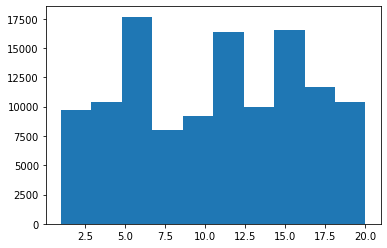

In [97]:
# View distribution of articles over topics
plt.hist(df_articles["topic"])
plt.show()